# Parameter Estimation Workflow for conversion reaction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from scipy.stats import norm
from scipy.integrate import dblquad
import random

from bayesflow.networks import InvertibleNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.diagnostics import *
from bayesflow.models import GenerativeModel

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
v = np.array([-9.113875, -11.310476, -8.2872505, -10.54476, -8.117575, -11.136318, -9.266106, -7.73474, -10.333131, -9.510155, -8.238766, -9.944189, -8.9775305, -9.04681, -10.33249, -10.711512, -7.5435457, -9.502764, -10.800597, -10.686707, -9.374997, -10.345003, -9.255559, -9.416227, -9.948053, -11.182295, -9.832298, -8.821349, -8.824957, -8.6867695, -8.978771, -7.6001835, -9.98851, -9.292133, -8.098011, -10.671668, -11.037193, -9.794924, -11.049173, -10.075142, -10.429117, -8.138342, -10.159193, -9.13026, -7.9252295, -8.948734, -10.043711, -7.64032, -8.299389, -9.406488, -8.543507, -10.335314, -10.015106, -10.033143, -10.231592, -11.457951, -9.57312, -9.522915, -8.740968, -10.29196, -10.441295, -9.460025, -11.4670925, -11.391092, -10.2115135, -11.182396, -8.4784975, -10.209158, -9.144335, -10.520847, -10.498493, -10.084471, -10.971392, -8.356648, -10.338144, -9.914158, -10.832222, -10.79602, -9.5734825, -8.403, -8.818678, -10.19599, -9.685411, -10.346811, -8.571618, -7.8417788, -9.864542, -9.849745, -10.072355, -9.886987, -10.325256, -11.068722, -10.228035, -10.752715, -11.355505, -10.406319, -11.521872, -10.316283, -8.545432, -10.427101, -10.692781, -9.995923, -11.56888, -10.25729, -9.396263, -7.4084253, -11.549109, -11.282814, -9.281181, -10.001549, -11.313099, -8.719627, -9.050135, -7.574344, -9.345818, -9.4202175, -10.789765, -10.138255, -11.259996, -11.515255, -10.046385, -9.786986, -8.926989, -10.524418, -11.1117325, -10.886574, -11.21064, -10.958195, -10.871559, -8.476828, -10.82054, -8.653746, -9.683085, -11.352435, -7.4202547, -10.497211, -9.969235, -11.494913, -10.842953, -8.882566, -9.434487, -8.466348, -11.509204, -9.843893, -10.977273, -11.014684, -9.154261, -11.479243, -9.011223, -8.500396, -11.242864, -11.599716, -11.331155, -10.771975, -9.228777, -10.753807, -11.09881, -7.236249, -10.68475, -9.320036, -8.313889, -10.091936, -10.642351, -10.124358, -11.099444, -10.985131, -9.0795555, -9.675975, -10.881034, -10.544376, -11.038149, -10.912247, -11.643006, -11.131044, -10.691531, -10.698426])
len(v)

176

In [4]:
a = np.array([-11.287092, -11.266167, -11.424382, -11.404546, -11.322956, -11.5499325, -11.332531, -11.367722, -11.38579, -11.57604, -11.19039, -11.517872, -11.362757, -11.27727, -11.3359165, -11.300016, -11.483875, -11.227716, -11.396701, -11.430585, -11.340517, -11.276858, -11.652269, -11.332556, -11.423417, -11.285089, -11.19577, -11.248344, -11.3828, -11.248393, -11.3342285, -11.242138, -11.245977, -11.18539, -11.331036, -11.241112, -11.206524, -11.298032, -11.30253, -11.454336, -11.414179, -11.247328, -11.391109, -11.301708, -11.412317, -11.163834, -11.383601, -11.342005, -11.38262, -11.556067, -11.375229, -11.319269, -11.501503, -11.426517, -11.429268, -11.54156, -11.176588, -11.364075, -11.295992, -11.102154, -11.147774, -11.353462, -11.039274, -11.456806, -11.309675, -11.236963, -11.26001, -11.313065, -11.348303, -11.375529, -11.570393, -11.312145, -11.356211, -11.48312, -11.438703, -11.311235, -11.374418, -11.288872, -11.576415, -11.317391, -11.248425, -11.235008, -11.293581, -11.452902, -11.390059, -11.231373, -11.36007, -11.440527, -11.335652, -11.35029, -11.39659, -11.297356, -11.443982, -11.333763, -11.134079, -11.43236, -11.389074, -11.497864, -11.410522, -11.240932, -11.27204, -11.454228, -11.41032, -11.484166, -11.490541, -11.2171335, -11.424569, -11.281614, -11.471115, -11.402603, -11.231142, -11.11153, -11.235689, -11.5280695, -11.489172, -11.21407, -11.304217, -11.222675, -11.28174, -11.260884, -11.548463, -11.390744, -11.254932, -11.514888, -11.31189, -11.319243, -11.428198, -11.2886305, -11.351858, -11.474585, -11.428143, -11.479305, -11.287835, -11.274441, -11.257778, -11.319851, -11.171909, -11.3646965, -11.275643, -11.248228, -11.323292, -11.216693, -11.288815, -11.253229, -11.400949, -11.441595, -11.357854, -11.485855, -11.355773, -11.299402, -11.363436, -11.261099, -11.383786, -11.173203, -11.351809, -11.327366, -11.185286, -11.440657, -11.137106, -11.344285, -11.387962, -11.332998, -11.168011, -11.287241, -11.259921, -11.37121, -11.218763, -11.394407, -11.243401, -11.335551, -11.311618, -11.563345, -11.38734, -11.213414, -11.442862, -11.251112])
len(a)

176

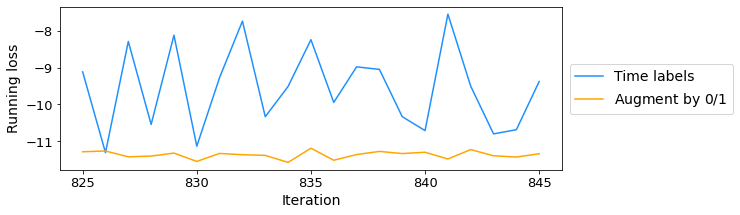

In [37]:
# Visualize running loss
augment01 = a[:21]
timelabels = v[:21]

fig = plt.figure(figsize=(9, 3))
plt.rcParams['font.size'] = 13

plt.plot(np.arange(825, 846, 1), timelabels, color='dodgerblue', label='Time labels')
plt.plot(np.arange(825, 846, 1), augment01, color='orange', label='Augment by $0/1$') 

plt.xticks([825, 830, 835, 840, 845])
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Running loss', fontsize=14)
plt.legend(fontsize=14, bbox_to_anchor=(1.355,.69))
plt.show()
fig.savefig("Oscillation_running_loss.png", dpi=600, bbox_inches='tight')

## Simulator settings

In [3]:
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------
    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) 
    """    
    # Prior range: frequency parameter a ~ U(0.1, 1) & shift parameter b ~ N(0, 0.25²)
    freq_samples = np.random.uniform(0.1, 1.0, size=(batch_size, 1))
    shift_samples = np.random.normal(0.0, 0.25, size=(batch_size, 1))
    p_samples = np.c_[freq_samples, shift_samples]
    return p_samples.astype(np.float32)


# Oscillation model        
n_obs = 41  
time_points = np.linspace(0, 10, n_obs)
sigma = 0.05   # noise standard deviation
missing_max = 21


def batch_simulator_augment01(prior_samples, n_obs):   
    """
    Simulate multiple oscillation model datasets with missing values and augmentation by zeros/ones
    """    
    n_sim = prior_samples.shape[0]   # batch size    
    sim_data = np.ones((n_sim, n_obs, 2), dtype=np.float32)   # 1 batch consisting of n_sim datasets, each with n_obs observations  
    n_missing = np.random.randint(0, missing_max+1, size=n_sim)
    
    for m in range(n_sim):
        a = prior_samples[m, 0]   # frequency
        b = prior_samples[m, 1]   # shift
        sim_data[m, :, 0] = np.sin(a*2*np.pi*time_points) + b + np.random.normal(0, sigma, size=n_obs)
        
        # artificially induce missing data
        missing_indices = random.sample(range(n_obs), n_missing[m])
        sim_data[m][missing_indices] = np.array([-5.0, 0.0])
        
    return sim_data   


def batch_simulator_timepoints(prior_samples, n_obs):   
    """
    Simulate multiple oscillation model datasets with missing values and time labels (present time points)
    """    
    n_sim = prior_samples.shape[0]   # batch size    
    n_missing = np.random.randint(0, missing_max+1)
    n_present = n_obs - n_missing
    sim_data = np.empty((n_sim, n_present, 2), dtype=np.float32)   # 1 batch consisting of n_sim datasets, each with n_present observations
    
    for m in range(n_sim):
        a = prior_samples[m, 0]   # frequency
        b = prior_samples[m, 1]   # shift
        
        # artificially induce missing data
        missing_indices = random.sample(range(n_obs), n_missing)
        present_indices = np.setdiff1d(range(n_obs), missing_indices)
        present_timepoints = time_points[present_indices]
        sim_data[m, :, 0] = np.sin(a*2*np.pi*present_timepoints) + b + np.random.normal(0, sigma, size=n_present)
        sim_data[m, :, 1] = present_timepoints   # time labels
        
    return sim_data   

We build an amortized parameter estimation network.

In [4]:
bf_meta = {
    'n_coupling_layers': 5,
    's_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': 2
}

## Computational faithfulness

In [5]:
def batch_simulator_analysis(prior_samples, n_missing):      
    a = prior_samples[0, 0]   # frequency
    b = prior_samples[0, 1]   # shift
    data_original = np.sin(a*2*np.pi*time_points) + b + np.random.normal(0, sigma, size=n_obs)
             
    # artificially induce missing data
    missing_indices = random.sample(range(n_obs), n_missing)
    present_indices = np.setdiff1d(range(n_obs), missing_indices)
    
    # returns original data, present indices, present timepoints, augmented data
    return [data_original, present_indices, time_points[present_indices]] 

In [6]:
param_prior = np.array([[0.2, -0.4]])   
result = batch_simulator_analysis(param_prior, 20)
param_prior[0]

array([ 0.2, -0.4])

In [7]:
result

[array([-0.36968572, -0.09606771,  0.18028771,  0.41438589,  0.50673744,
         0.64886439,  0.63786974,  0.46521531,  0.19867711, -0.17299197,
        -0.35704604, -0.72558247, -0.94090854, -1.19593017, -1.28373962,
        -1.47586103, -1.33144932, -1.20361991, -0.93085996, -0.68046031,
        -0.43030265, -0.15195662,  0.15587731,  0.38293959,  0.62851532,
         0.6651175 ,  0.54870718,  0.36267484,  0.09364889, -0.08283403,
        -0.26498839, -0.79600325, -0.96046877, -1.22965668, -1.40916667,
        -1.47128252, -1.32202451, -1.23141855, -1.00466763, -0.70441362,
        -0.44515639]),
 array([ 0,  2,  5,  7,  8,  9, 11, 13, 14, 15, 16, 17, 21, 24, 27, 28, 30,
        33, 34, 35, 38]),
 array([0.  , 0.5 , 1.25, 1.75, 2.  , 2.25, 2.75, 3.25, 3.5 , 3.75, 4.  ,
        4.25, 5.25, 6.  , 6.75, 7.  , 7.5 , 8.25, 8.5 , 8.75, 9.5 ])]

In [25]:
# Demo dataset 1 (n_missing = 20, single mode)
param_prior = np.array([[0.95, 0.1]])
result = [np.array([ 0.0411556 ,  1.08346297,  0.2623786 , -0.92034164, -0.17167728,
         1.02610335,  0.54370587, -0.78445069, -0.52135847,  0.85621658,
         0.77392383, -0.61739495, -0.73033272,  0.55306994,  1.02138007,
        -0.28863467, -0.77016348,  0.38925967,  1.03721564,  0.0408748 ,
        -0.91261586, -0.00819852,  1.12443804,  0.37746972, -0.84010395,
        -0.32655636,  0.99065733,  0.55809712, -0.67683952, -0.53908892,
         0.76198376,  0.88392371, -0.56456167, -0.77304082,  0.58618039,
         0.99736459, -0.13568713, -0.96373333,  0.26542047,  1.05570096,
         0.07219064]),
 np.array([ 1,  4,  5,  7,  9, 12, 14, 15, 16, 19, 21, 22, 24, 26, 27, 28, 32,
        33, 36, 37, 38]),
 np.array([0.25, 1.  , 1.25, 1.75, 2.25, 3.  , 3.5 , 3.75, 4.  , 4.75, 5.25,
        5.5 , 6.  , 6.5 , 6.75, 7.  , 8.  , 8.25, 9.  , 9.25, 9.5 ])]

In [12]:
# Demo dataset 2 (n_missing = 5, single mode)
param_prior = np.array([[0.95, 0.1]])
result = [np.array([ 0.06558115,  1.1529961 ,  0.26845356, -0.87400005, -0.19555278,
         0.98471461,  0.56318483, -0.68400939, -0.45881125,  0.85935282,
         0.82750909, -0.57652126, -0.69450701,  0.55397458,  0.99007411,
        -0.33538877, -0.80158239,  0.35647984,  1.08639333,  0.02265818,
        -0.83922163,  0.05430785,  1.13427565,  0.38743553, -0.73212583,
        -0.21272149,  0.99785238,  0.66780864, -0.73831262, -0.55276381,
         0.85825585,  0.82742041, -0.47542639, -0.6993957 ,  0.65552565,
         1.05295441, -0.13560604, -0.89603827,  0.3017642 ,  1.1759054 ,
         0.04112956]),
 np.array([ 0,  1,  2,  4,  5,  7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 19, 20,
        21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
        39, 40]),
 np.array([ 0.  ,  0.25,  0.5 ,  1.  ,  1.25,  1.75,  2.  ,  2.25,  2.5 ,
         2.75,  3.  ,  3.5 ,  3.75,  4.  ,  4.25,  4.75,  5.  ,  5.25,
         5.5 ,  5.75,  6.  ,  6.5 ,  6.75,  7.  ,  7.25,  7.5 ,  7.75,
         8.  ,  8.25,  8.5 ,  8.75,  9.  ,  9.25,  9.5 ,  9.75, 10.  ])]

In [15]:
# Demo dataset 3 (n_missing = 15, single mode)
param_prior = np.array([[0.2, -0.4]])
result = [np.array([-0.38822525, -0.07585579,  0.09875853,  0.42901483,  0.48185913,
         0.62969871,  0.6457469 ,  0.434365  ,  0.20191629, -0.12380711,
        -0.41445603, -0.71438838, -1.10485856, -1.23079156, -1.36338658,
        -1.44566409, -1.45376767, -1.25233028, -0.98761422, -0.76457333,
        -0.41138701, -0.06165886,  0.19041922,  0.33472721,  0.54920351,
         0.63987353,  0.52822556,  0.4772211 ,  0.0992428 , -0.08048652,
        -0.37974125, -0.6531358 , -1.05218318, -1.23381172, -1.34811474,
        -1.42620643, -1.39496478, -1.15792385, -0.91626909, -0.72581709,
        -0.34380109]),
 np.array([ 0,  1,  2,  3,  4,  5,  6,  9, 11, 13, 14, 16, 17, 19, 20, 24, 25,
        27, 28, 29, 30, 31, 33, 36, 37, 39]),
 np.array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 2.25, 2.75, 3.25, 3.5 ,
        4.  , 4.25, 4.75, 5.  , 6.  , 6.25, 6.75, 7.  , 7.25, 7.5 , 7.75,
        8.25, 9.  , 9.25, 9.75])]

In [42]:
# Demo dataset 4 (n_missing = 15, single mode)
param_prior = np.array([[0.6, 0.3]])
result = [np.array([ 0.32543862,  1.13268252,  1.29125217,  0.60607818, -0.26472148,
        -0.67062413, -0.36670598,  0.61192179,  1.22621554,  1.16430779,
         0.32519066, -0.44656801, -0.74323756, -0.01174657,  0.88601982,
         1.38143747,  0.89709771,  0.00760059, -0.74576954, -0.4780118 ,
         0.37640507,  1.15296282,  1.28852993,  0.57043108, -0.28242796,
        -0.68878975, -0.31081723,  0.65473874,  1.21686616,  1.1298416 ,
         0.32988362, -0.56830772, -0.67198148, -0.00467862,  0.83856425,
         1.307288  ,  0.90877165,  0.04996764, -0.64807895, -0.49669089,
         0.3011113 ]),
 np.array([ 0,  2,  4,  5,  6,  7,  8,  9, 11, 12, 13, 14, 16, 17, 20, 21, 23,
        25, 26, 27, 28, 29, 33, 34, 38, 39]),
 np.array([0.  , 0.5 , 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.75, 3.  , 3.25,
        3.5 , 4.  , 4.25, 5.  , 5.25, 5.75, 6.25, 6.5 , 6.75, 7.  , 7.25,
        8.25, 8.5 , 9.5 , 9.75])]

In [12]:
# Demo dataset 5 (n_missing = 15, single mode)
param_prior = np.array([[0.95, 0.1]])
result = [np.array([ 0.12915902,  1.09655196,  0.25132037, -0.85228722, -0.16836471,
         0.96387923,  0.64649746, -0.80693706, -0.43400016,  0.87861574,
         0.95204841, -0.57116731, -0.6383823 ,  0.58252093,  0.9997371 ,
        -0.20291682, -0.88444767,  0.28103924,  1.05966781, -0.00883805,
        -0.88074656, -0.0535541 ,  1.04600624,  0.29553028, -0.82083289,
        -0.23829157,  1.0298198 ,  0.63870846, -0.72123813, -0.59326197,
         0.74059779,  0.93637972, -0.54706757, -0.80130839,  0.61548954,
         1.00897363, -0.25526025, -0.8486037 ,  0.27934963,  1.09537449,
         0.15027804]),
 np.array([ 1,  2,  3,  5,  6,  8, 11, 12, 15, 16, 17, 19, 21, 22, 23, 25, 28,
        29, 32, 34, 35, 36, 37, 38, 39, 40]),
 np.array([ 0.25,  0.5 ,  0.75,  1.25,  1.5 ,  2.  ,  2.75,  3.  ,  3.75,
         4.  ,  4.25,  4.75,  5.25,  5.5 ,  5.75,  6.25,  7.  ,  7.25,
         8.  ,  8.5 ,  8.75,  9.  ,  9.25,  9.5 ,  9.75, 10.  ])]

In [26]:
# Method 1: augment01
summary_net = LSTM(128)
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
trainer = ParameterEstimationTrainer(network=amortizer, checkpoint_path='./Oscillation41_augment01_5ACB_[64,64,64]_LSTM(128)_ckpts', 
                                     skip_checks=True)
sim_data = np.ones((1, n_obs, 2), dtype=np.float32)
sim_data[0, :, 0] = result[0]
missing_indices = np.setdiff1d(range(n_obs), result[1])
sim_data[0][missing_indices] = np.array([-5.0, 0.0])
x_data = sim_data
param_samples_11 = amortizer.sample(x_data, n_samples=7500)
mean_sample = np.mean(param_samples_11, axis=0)
cov_sample = np.cov(param_samples_11.transpose())
mean_x = mean_sample[0]
mean_y = mean_sample[1]
std_x = np.sqrt(cov_sample[0, 0])
std_y = np.sqrt(cov_sample[1, 1])

# Method 3: timepoints
summary_net = LSTM(128)
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
trainer = ParameterEstimationTrainer(network=amortizer, checkpoint_path='./Oscillation41_timepoints_5ACB_[64,64,64]_LSTM(128)_ckpts', 
                                     skip_checks=True)
n_present = len(result[1])
sim_data = np.ones((1, n_present, 2), dtype=np.float32)
sim_data[0, :, 0] = result[0][result[1]]
sim_data[0, :, 1] = result[2]
x_data = sim_data
param_samples_33 = amortizer.sample(x_data, n_samples=7500)

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./Oscillation41_augment01_5ACB_[64,64,64]_LSTM(128)_ckpts\ckpt-300
TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./Oscillation41_timepoints_5ACB_[64,64,64]_LSTM(128)_ckpts\ckpt-300


In [27]:
def prior_eval(a,b):   
    # Evaluates prior probability p(theta) according to a ~ U(0.1, 1) & shift parameter b ~ N(0, 0.25²)
    if a > 0.1 and a < 1.0:
        return 1/0.9 * norm.pdf(b, 0.0, 0.25)
    else: 
        return 0.

def likelihood(a,b):   
    # Calculates likelihood of available data
    residual = (result[0][result[1]] - (np.sin(a*2*np.pi*result[2]) + b))/sigma
    nllh = np.sum(np.log(2*np.pi*sigma**2)+residual**2)/2
    return np.exp(-nllh)

def unnormalized_posterior(a,b):   
    # Evaluates the unnormalized posterior probability according to Bayes' formula
    return likelihood(a,b) * prior_eval(a,b)

# scaling factor
scaling_factor = dblquad(unnormalized_posterior, mean_y-10*std_y, mean_y+10*std_y, lambda y: mean_x-10*std_x, lambda y: mean_x+10*std_x)
print(scaling_factor)
# normalized posterior
posterior_xy = lambda x,y: unnormalized_posterior(x,y)/scaling_factor[0]

# Level sets of analytic posterior distribution
grid = 201
A = np.linspace(mean_x - 3 * std_x, mean_x + 3 * std_x, grid)
B = np.linspace(mean_y - 3 * std_y, mean_y + 3 * std_y, grid)
true_posterior = np.zeros((grid, grid))
for iy in range(0, grid):
    for ix in range(0, grid):
        true_posterior[iy][ix] = posterior_xy(A[ix], B[iy])
        
# Check marginal densities
grid = 151
C = np.linspace(mean_x - 5 * std_x, mean_x + 5 * std_x, grid)
D = np.linspace(mean_y - 5 * std_y, mean_y + 5 * std_y, grid)
bounds = np.array([mean_x - 10 * std_x, mean_x + 10 * std_x, mean_y - 10 * std_y, mean_y + 10 * std_y])
marginal_x = np.zeros(grid)
for i in range(grid):
    x = C[i]
    integrand_y = lambda y: posterior_xy(x, y)
    marginal_x[i] = quad(integrand_y, bounds[2], bounds[3])[0]
marginal_y = np.zeros(grid)
for j in range(grid):
    y = D[j]
    integrand_x = lambda x: posterior_xy(x, y)
    marginal_y[j] = quad(integrand_x, bounds[0], bounds[1])[0] 

(188148766902.4768, 2573.3227473795414)


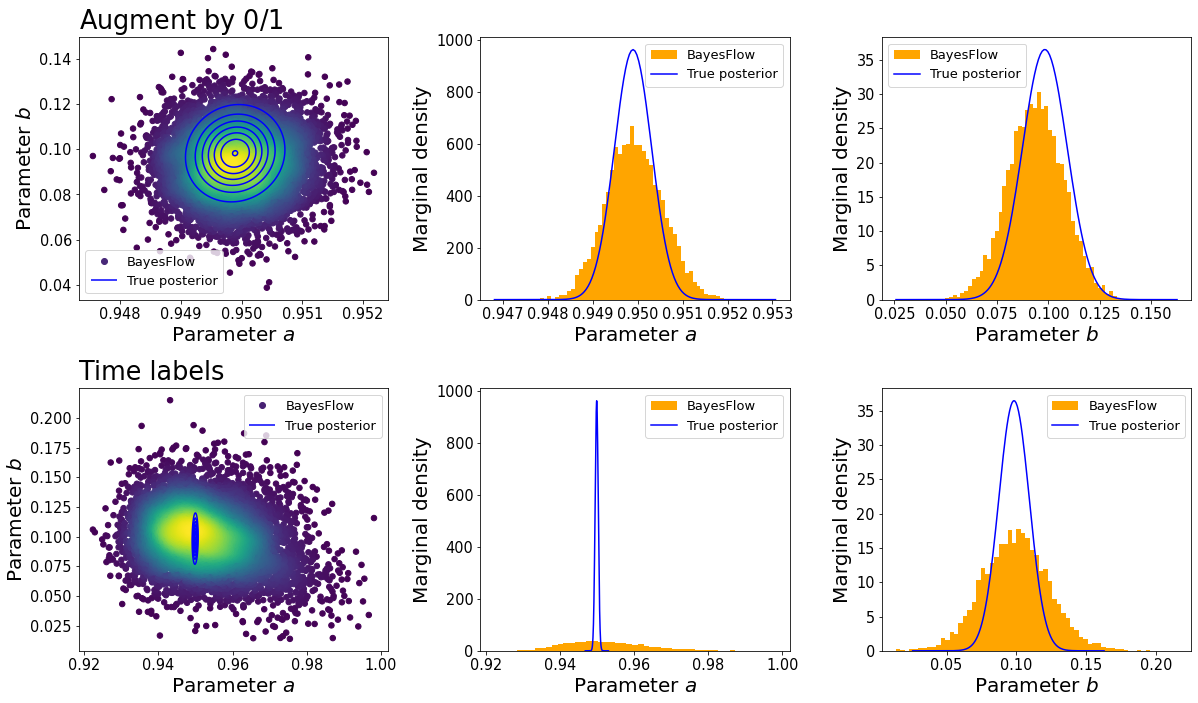

In [35]:
fig = plt.figure(figsize=(16.75, 10))
plt.rcParams['font.size'] = 14.5

plot_posterior_comparison(param_samples_11, A, B, C, D, true_posterior, marginal_x, marginal_y, 1, 'Augment by $0/1$',
                          levels=None, label_1='True posterior', label_2='BayesFlow')
plot_posterior_comparison(param_samples_33, A, B, C, D, true_posterior, marginal_x, marginal_y, 2, 'Time labels', 
                          levels=None, label_1='True posterior', label_2='BayesFlow')

plt.tight_layout()
plt.show()
fig.savefig("figures/{}_posterior_comparison.png".format('Oscillation_1'), dpi=300, bbox_inches='tight')   

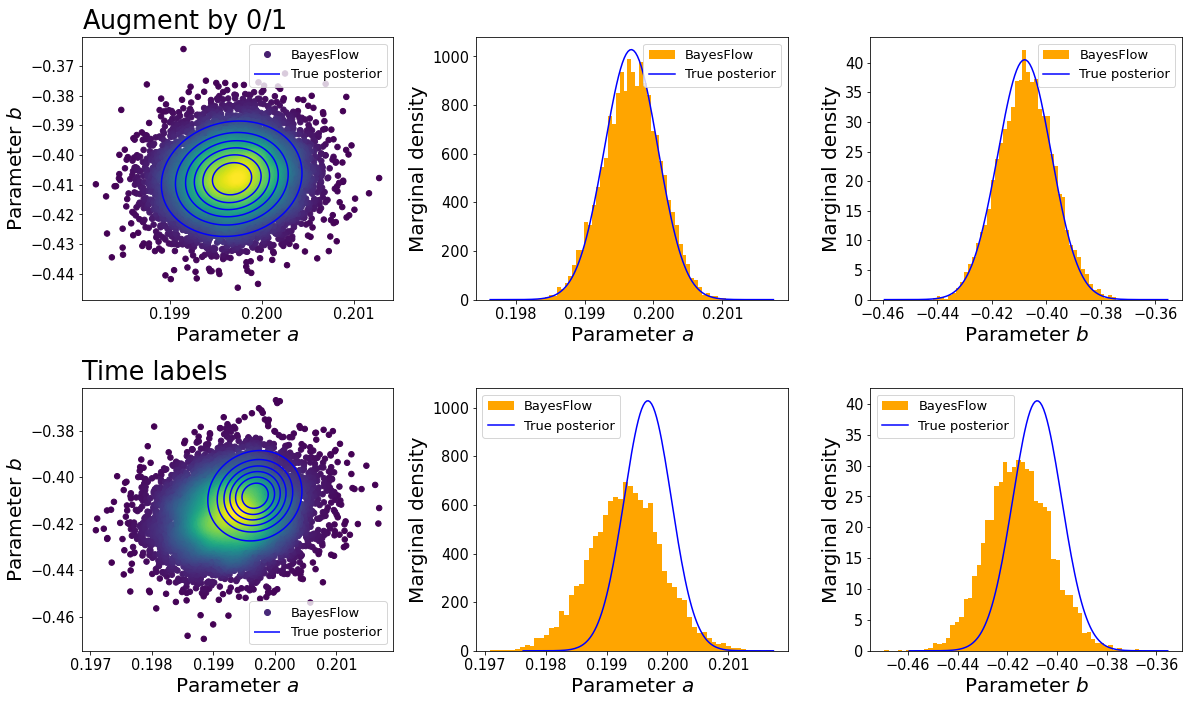

In [24]:
fig = plt.figure(figsize=(16.75, 10))
plt.rcParams['font.size'] = 14.5

plot_posterior_comparison(param_samples_1, A, B, C, D, true_posterior, marginal_x, marginal_y, 1, 'Augment by $0/1$',
                          levels=None, label_1='True posterior', label_2='BayesFlow')
plot_posterior_comparison(param_samples_3, A, B, C, D, true_posterior, marginal_x, marginal_y, 2, 'Time labels', 
                          levels=None, label_1='True posterior', label_2='BayesFlow')

plt.tight_layout()
plt.show()
fig.savefig("figures/{}_posterior_comparison.png".format('Oscillation_3'), dpi=300, bbox_inches='tight')   

augment01, timepoints

SBC plot: similarly good => no systematic bias